In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load Data

In [25]:
food_orders = pd.read_csv('food_orders_new_delhi.csv')
food_orders.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [26]:
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


- No missing columns in any column
- Data cleaning:
    + Convert "Order Date and Time" and "Delivery Data and Time" to datetime format
    + Convert "Discounts and Offers" to numeric value (calculate discount amounts)

# Clean Data

In [27]:
# Convert date and time columns to datetime format
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

In [28]:
# Helper function to extract numeric values from 'Discounts and Offers'
# 2 types of discounts: exact amount off from total or percentage off
def extract_discount(input):
    if not isinstance(input, str):
        return ('none', 0.0)
    if 'off' in input:
        discount = float(input.split(' ')[0])
        return ('fixed', discount)
    elif '%' in input:
        discount = float(input.split('%')[0])
        return ('percentage', discount)
    return ('none', 0.0)

# Extract discount type and value
food_orders[['Discount Type', 'Discount Value']] = food_orders['Discounts and Offers'].apply(
    lambda x: pd.Series(extract_discount(x))
)


In [29]:
# Calculate discount amount
def calculate_discount_amount(row):
    if row['Discount Type'] == 'percentage':
        return row['Order Value'] * row['Discount Value'] / 100
    elif row['Discount Type'] == 'fixed':
        return row['Discount Value']
    return 0.0
food_orders['Discount Amount'] = food_orders.apply(calculate_discount_amount, axis = 1)
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                1000 non-null   int64         
 1   Customer ID             1000 non-null   object        
 2   Restaurant ID           1000 non-null   object        
 3   Order Date and Time     1000 non-null   datetime64[ns]
 4   Delivery Date and Time  1000 non-null   datetime64[ns]
 5   Order Value             1000 non-null   int64         
 6   Delivery Fee            1000 non-null   int64         
 7   Payment Method          1000 non-null   object        
 8   Discounts and Offers    815 non-null    object        
 9   Commission Fee          1000 non-null   int64         
 10  Payment Processing Fee  1000 non-null   int64         
 11  Refunds/Chargebacks     1000 non-null   int64         
 12  Discount Type           1000 non-null   object   

# Cost and Profitability Analysis

In [30]:
#  Calculate total costs, revenue and profit for the platform
food_orders['Total Costs'] = (food_orders['Payment Processing Fee'] 
                              + food_orders['Discount Amount']
                              + food_orders['Delivery Fee'])
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

In [31]:
# Aggregate data to get overall metrics 
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}
print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Costs': 132741.84999999998, 'Total Profit': -5751.85}


# Visualization

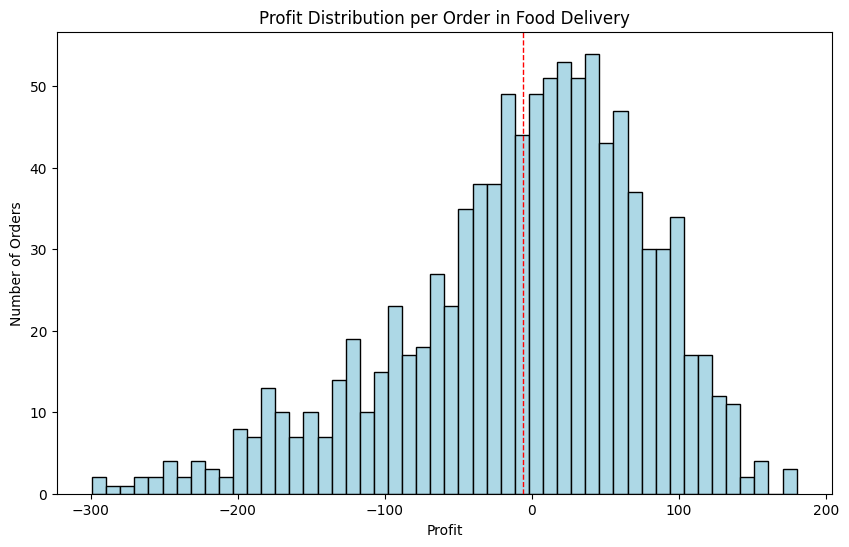

In [32]:
# Profit Distribution Per Order

plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='lightblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

The histogram shows the distribution of profit per food order across 1000 deliveries. The data reveals:
- Mean profit is slightly below zero, indicated by the red dashed line - the platform is operating at a small loss per order on average.
- Most orders fall between -50 and +50 in profit, but there is a long tail of loss-making orders, some exceeding -300 in loss.
- The distribution is slightly left-skewed, with more extreme losses than gains.

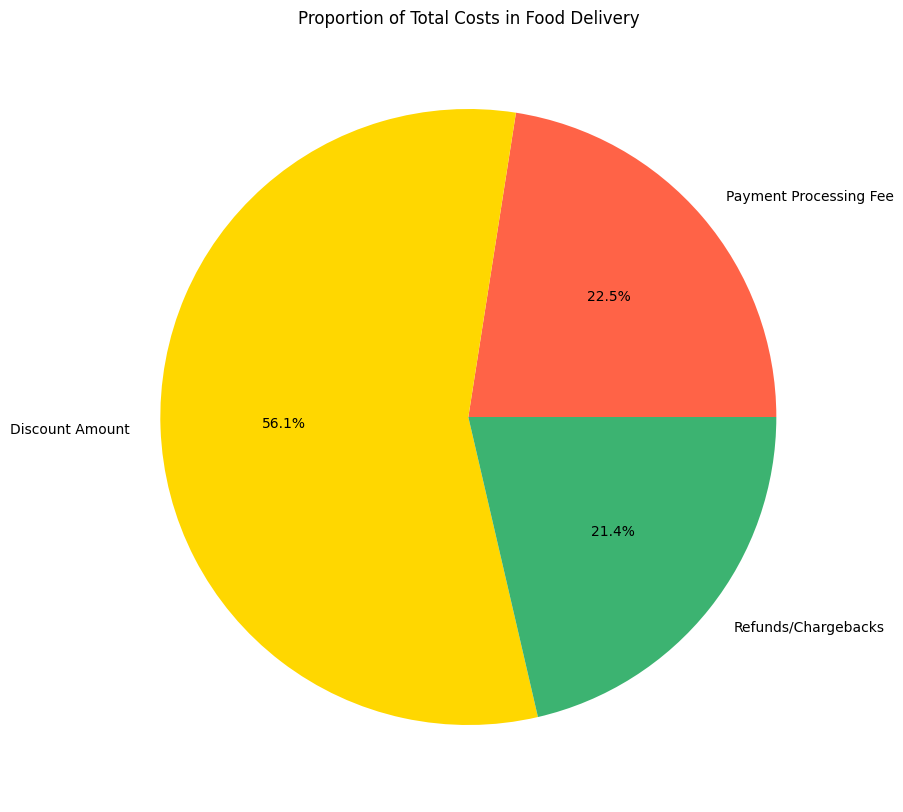

In [33]:
# Proporotion of total costs
costs_breakdown = {
    'Payment Processing Fee': food_orders['Payment Processing Fee'].sum(),
    'Discount Amount': food_orders['Discount Amount'].sum(),
    'Refunds/Chargebacks': food_orders['Refunds/Chargebacks'].sum()
}
costs_series = pd.Series(costs_breakdown)
plt.figure(figsize=(10,10))
plt.pie(costs_series.values, labels=costs_series.index, autopct='%1.1f%%',
        startangle=0, colors=['tomato', 'gold', '#3CB371'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

The pie chart reflects the breakdown of total costs in our operation. Discounts constitute a significant portion of the costs, suggesting that our promotional strategies might be heavily impacting overall profitability.

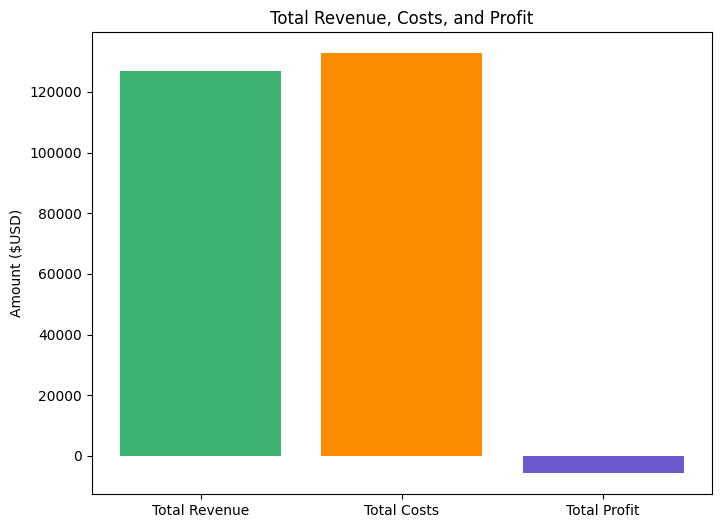

In [34]:
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
vals = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8,6))
plt.bar(totals, vals, color=['#3CB371', '#FF8C00', '#6A5ACD'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount ($USD)')
plt.show()

This bar chart shows that total costs exceed total revenue, resulting in a net loss for the platform. While the gap isn't massive, the platform is currently not profitable and needs to reduce costs or adjust pricing to improve margins.

# Recommendations

From the analysis, our promotional strategies are resulting in huge losses. Hence, we need to find a new strategy for our discount.

In [35]:
# Calculate average commission percentage for all orders
food_orders.loc[:, 'Commission Percentage'] = (food_orders['Commission Fee'] / food_orders['Order Value']) * 100
food_orders.loc[:, 'Discount Percentage'] = (food_orders['Discount Amount'] / food_orders['Order Value']) * 100

# Original average percentages
original_avg_commission_percentage = food_orders['Commission Percentage'].mean()
original_avg_discount_percentage = food_orders['Discount Percentage'].mean()

# Profitable average percentages
new_avg_commission_percentage = food_orders.loc[food_orders['Profit'] > 0, 'Commission Percentage'].mean()
new_avg_discount_percentage = food_orders.loc[food_orders['Profit'] > 0, 'Discount Percentage'].mean()


In [36]:
print(f'Original average commission percentage per order: {original_avg_commission_percentage}')
print(f'Original average discount percentage per order: {original_avg_discount_percentage}')
print(f'Profitable average commission percentage per order: {new_avg_commission_percentage}')
print(f'Profitable average discount percentage per order: {new_avg_discount_percentage}')


Original average commission percentage per order: 19.750890168545332
Original average discount percentage per order: 7.6546113985795
Profitable average commission percentage per order: 27.706528082159736
Profitable average discount percentage per order: 5.623712042253798


Based on the refined analysis of profitable orders, we observe a new average commission percentage of 27.7% and an avarage discount percentage of 5.6%. These averages are signicantly different from the overall averages and may present a potential for increasing profitability.


In [37]:
# Simulate profitability with recommended discounts and commissions (round up)
recommended_commission_percentage = 30
recommended_discount_percentage = 6.0

# Caculate the simulated commission fee and discount amount using the recommended metrics
food_orders['Simulated Commission Fee(R)'] = food_orders['Order Value'] * (recommended_commission_percentage/100)
food_orders['Simulated Discount Amount(R)'] = food_orders['Order Value'] * (recommended_discount_percentage/100)

# Recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs(R)'] = (food_orders['Delivery Fee'] +
                                           food_orders['Payment Processing Fee'] +
                                           food_orders['Simulated Discount Amount(R)'])

food_orders['Simulated Profit(R)'] = (food_orders['Simulated Commission Fee(R)'] -
                                      food_orders['Simulated Total Costs(R)'])

In [38]:
# Simulate profitability with recommended discounts and commissions (exact)
exact_commission_percentage = 27.7
exact_discount_percentage = 5.6

# Caculate the simulated commission fee and discount amount using the recommended metrics
food_orders['Simulated Commission Fee(E)'] = food_orders['Order Value'] * (
    exact_commission_percentage/100)
food_orders['Simulated Discount Amount(E)'] = food_orders['Order Value'] * (
    exact_discount_percentage/100)

# Recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs(E)'] = (food_orders['Delivery Fee'] +
                                           food_orders['Payment Processing Fee'] +
                                           food_orders['Simulated Discount Amount(E)'])

food_orders['Simulated Profit(E)'] = (food_orders['Simulated Commission Fee(E)'] -
                                      food_orders['Simulated Total Costs(R)'])

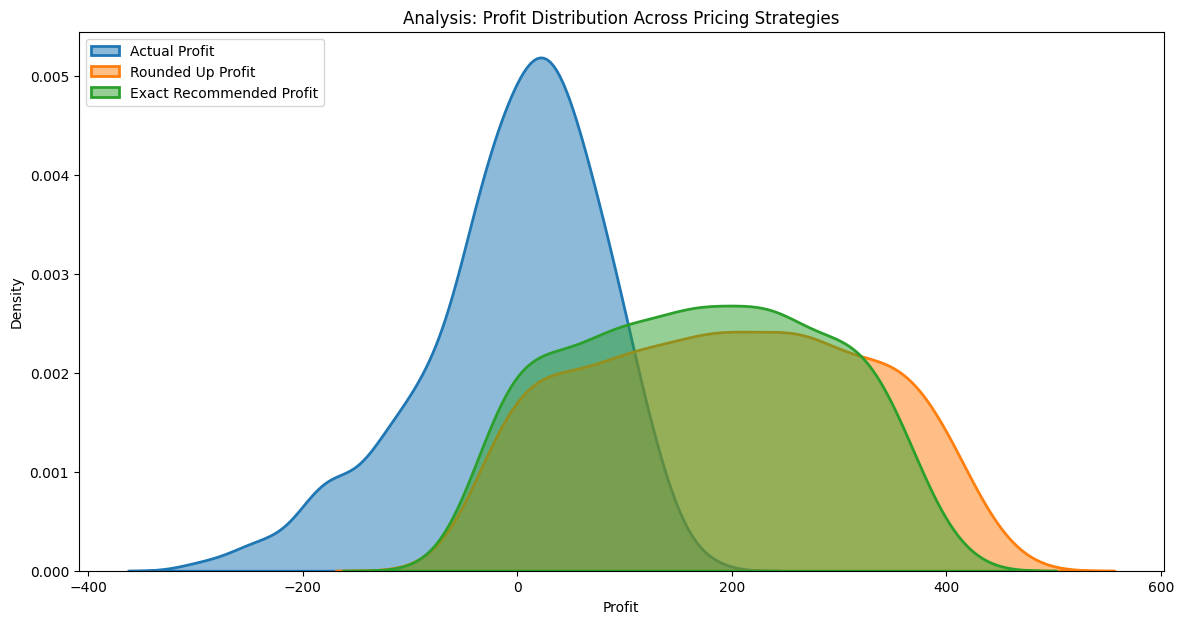

In [40]:
# Visualize to compare
plt.figure(figsize=(14,7))
sns.kdeplot(food_orders['Profit'], label='Actual Profit', fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(food_orders['Simulated Profit(R)'], label='Rounded Up Profit', fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(food_orders['Simulated Profit(E)'], label='Exact Recommended Profit', fill=True, alpha=0.5, linewidth=2)

plt.title('Analysis: Profit Distribution Across Pricing Strategies')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

This kernel density plot compares the distribution of profits under three different pricing strategies:
  1. Actual Profit(Blue)
  2. Simulated Profit with Rounded Up Strategy (R) (Orange)
  3. Simulated Profit with Exact Recommended Strategy (E) (Green)

Key Observations:
+ Actual Profit (Blue):
  - The distribution is centered around a lower profit value, the tail extends into the negative profit region, indicating that a substantial number of order are unprofitable under the current strategy.
+ Rounded Up Profit Strategy (Orange):
  - The curve shifts the distribution rightward, toward higher profits.
  - Fewer orders fall into the negative range, indicating that the strategy reduces loss frequency.
  - The curve is slightly wider, suggesting a broader distribution of profit outcomes, but the overall net profitability improves compared to the actuals.
+ Exact Recommended Strategy (Green):
  - The distribution concentrated more tightly and centered around a moderately high profit area (150-200), showing the most consistent and stable profitability with small amount of orders in the negative region.
  - This suggests that applying the optimal commission (27.7%) and discount (5.6%) creates a more predictable and reliable profit outcome across orders.

# Conclusion

Through a series of visualizations and simulations, we conducted a detailed analysis of profitability in our food delivery platform. The findings reveal clear trends and offer actionable insights into pricing, discounting, and cost management strategies.

### Profit Distribution (Actual Orders)

The histogram of actual profits shows that:

- The average profit per order is slightly negative, indicated by the red dashed mean line.

- A large number of orders fall into the loss-making range, with some exceeding –300 units in loss.

- The distribution is left-skewed, meaning more orders result in losses than gains.

This suggests that, in the current state, the platform is operating at a marginal net loss and many individual orders are not sustainably priced.

### Cost Structure Breakdown

The pie chart of total costs reveals:

+ Discounts are the largest single cost, accounting for over 56% of total operational expenses.
+ Payment processing fees (22.5%) and refunds/chargebacks (21.4%) also make up significant portions of the cost base.

This breakdown highlights that aggressive discounting strategies may be undermining profitability, and managing discounts more effectively could yield substantial improvements.



### Financial Overview: Revenue vs. Costs

The bar chart comparing total revenue, total costs, and total profit shows that:

- Total costs slightly exceed revenue, resulting in a net loss for the analyzed period.

- The platform’s current model is not far from break-even, but it is still not self-sustaining.

This calls for optimization—either by reducing cost components (primarily discounts) or adjusting pricing/commissions to improve margins.

### Recommendation and Strategy Simulation: Profit Distributions by Model

The kernel density plot compared profit outcomes under three pricing strategies:

+ Actual Strategy (Blue): Highest density of losses, significant negative tail.

+ Rounded-Up Strategy (Orange): Profitability improves, fewer losses, more orders shift into positive range.

+ Exact Recommended Strategy (Green): Most stable and profitable—tightly clustered around a strong profit center with minized losses

This simulation demonstrates that applying a data-driven pricing model—based on optimal commission (~27.7%) and discount (~5.6%) rates—can significantly improve profitability and consistency.



## Final Takeaway
The analysis clearly indicates that:

+ Over-discounting is the most critical factor driving unprofitability.

+ The current pricing structure is not optimized for sustainability.

+ Implementing optimized commission and discount policies can shift the majority of orders into profit and make the platform reliably profitable.

A shift toward controlled discounting, combined with strategic commission adjustments, can enhance unit-level economics and help the platform move toward profitable growth.

